# TP Noté : Discrétisation du modèle de Black-Scholes et pricing d'un option à barrière

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

## Partie 1 : Discrétisation de l'EDS de Black-Scholes

*Question 1*: La solution exacte de cette EDS est : $S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$

*Question 2* :

In [2]:
def S(t, S0, mu, sigma, W):
    """
    Solution exacte de l'EDS de Black-Scholes
    """
    return S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)


def euler_maruyama(mu, sigma, T, N, X0=0.0):
    """
    Simulation d'une EDS de Black-Scholes par la méthode d'Euler-Maruyama

    Paramètres :
        mu (float) : drift
        sigma (float) : volatilité
        T (int) : temps final
        N (int) : nombre de pas de temps
        X0 (float) : valeur initiale

    Retourne :
        t (array-like) : tableau des temps
        X (array-like) : tableau des valeurs de l'EDS
    """
    dt = T / N

    t = np.linspace(0, T, N + 1)
    X = np.zeros(N + 1)

    X[0] = X0

    dW = np.random.normal(0, np.sqrt(dt), N)

    for i in range(N):
        St = S(t[i], X[i], mu, sigma, dW[i])
        X[i + 1] = X[i] + mu * St * dt + sigma * St * dW[i]

    return t, X


def plot_brownien(t, X, B=None):
    """
    Plot la simulation d'Euler-Maruyama

    Paramètres :
        t (array-like) : tableau des temps
        X (array-like) : tableau des valeurs de l'EDS
        B (float) : barrière (optionnelle)
    """
    plt.plot(t, X, alpha=0.5, label="Euler-Maruyama")
    plt.title("Simulation d'Euler-Maruyama pour une EDS")

    if B is not None:
        plt.axhline(B, label="Barrière", color="red", linestyle="--")

    plt.legend()
    plt.xlabel("Temps")
    plt.ylabel("X(t)")
    plt.grid()

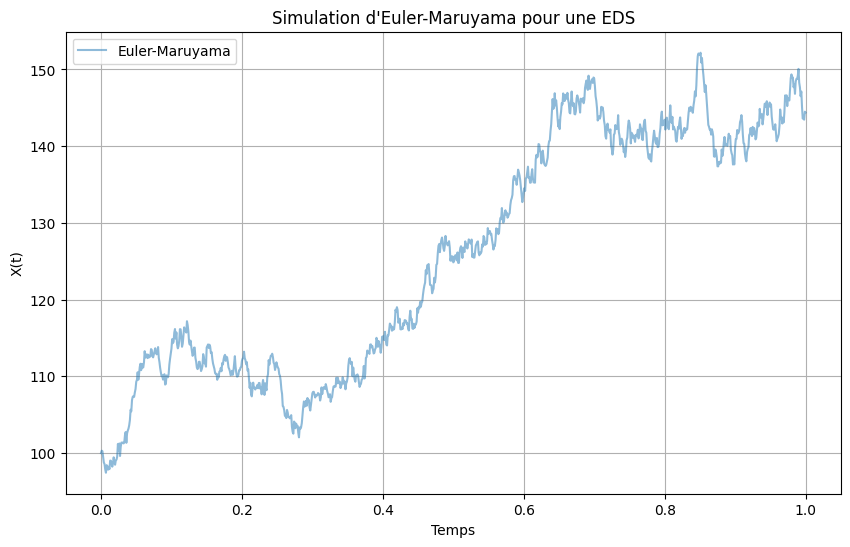

In [3]:
S0 = 100
K = 100
sigma = 0.2
r = 0.05
mu = r
T = 1
B = 120

t, X = euler_maruyama(mu=mu, sigma=sigma, T=T, N=1000, X0=S0)
plt.figure(figsize=(10, 6))
plot_brownien(t, X)
plt.show()

*Question 3*:

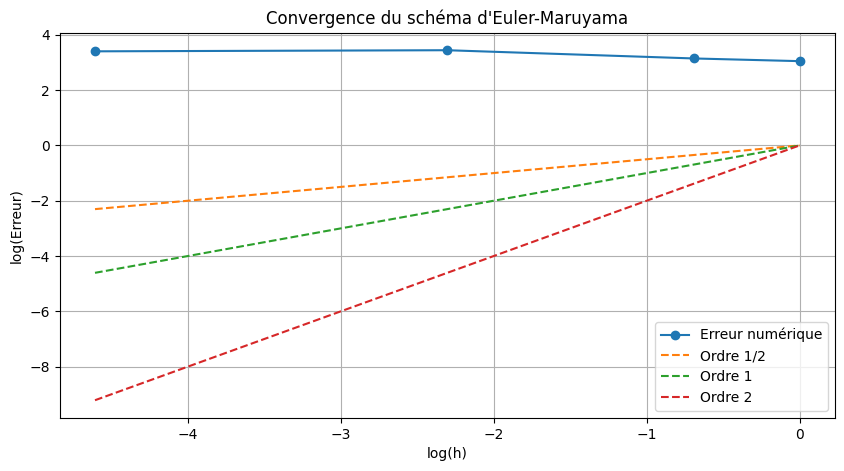

In [12]:
h_list = [0.01, 0.1, 0.5, 1.0]
N_list = [int(T / h) for h in h_list]

np.random.seed(333)


def plot_convergence(S0, mu, sigma, T):
    """
    Plot la convergence du schéma d'Euler-Maruyama

    Paramètres :
        S0 (int) : valeur initiale
        mu (float) : drift
        sigma (float) : volatilité
        T (int) : temps final
    """
    errors = []

    for N in N_list:
        dt = T / N
        dW = np.random.normal(0, np.sqrt(dt), N)

        exact = S(T, S0, mu, sigma, dW)
        _, X = euler_maruyama(mu=mu, sigma=sigma, T=T, N=N, X0=S0)

        errors.append(np.max(np.abs(X[1:] - exact)))

    plt.plot(np.log(h_list), np.log(errors), "o-", label="Erreur numérique")
    plt.plot(np.log(h_list), 0.5 * np.log(h_list), "--", label="Ordre 1/2")
    plt.plot(np.log(h_list), np.log(h_list), "--", label="Ordre 1")
    plt.plot(np.log(h_list), 2 * np.log(h_list), "--", label="Ordre 2")
    plt.xlabel("log(h)")
    plt.ylabel("log(Erreur)")
    plt.title("Convergence du schéma d'Euler-Maruyama")
    plt.legend()
    plt.grid(True)


plt.figure(figsize=(10, 5))
plot_convergence(S0, r, sigma, T)
plt.show()

L'ordre de convergence forte du schéma d'Euler-Maruyama est **${\frac{1}{2}}$**

## Partie 2 : Pricing d'une option à barrière de type "Up-and-Out Call"

*Question 1*: Sous la mesure risque-neutre, l'équation de Black-Scholes s'écrit :

$dS_t = r S_t dt + \sigma S_t d\tilde{W_t}$
- $r$ est le taux d'intérêt
- $\tilde{W_t} = W_t + \lambda t$ avec $\lambda = \frac{\mu - r}{\sigma}$

La solution s'écrit : $S_t = S_0 e^{(r - \frac{\sigma^2}{2})t + \sigma \tilde{W_t}}$

*Question 2*:

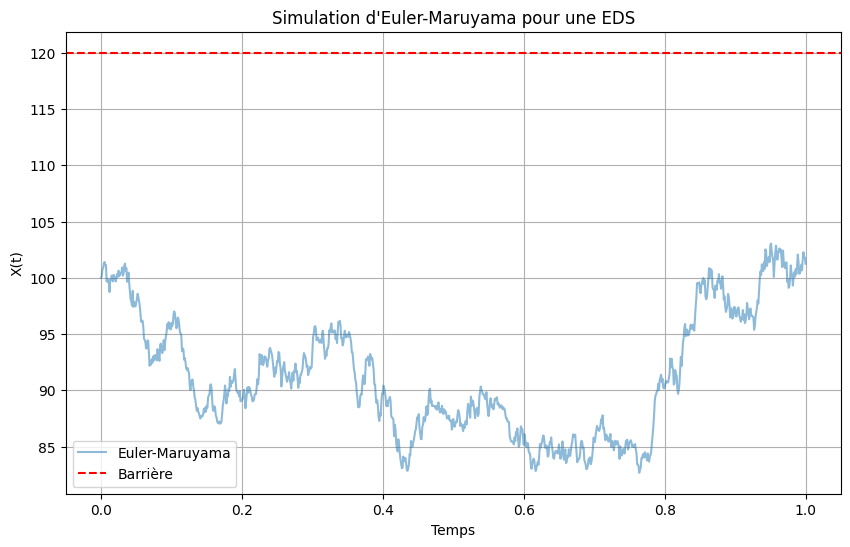

La barrière n'a pas été franchie


In [5]:
t, X = euler_maruyama(mu=r, sigma=sigma, T=T, N=1000, X0=S0)
plt.figure(figsize=(10, 6))
plot_brownien(t, X, B=B)
plt.show()


def is_barrier_breached(X, B):
    """Renvoie True si la barrière est franchie, False sinon
    La barrière est franchie si X >= B

    Paramètres:
        X (array-like): Trajectoire des valeurs
        B (float): Valeur de la barrière

    Retourne:
        bool: True si la barrière est franchie, False sinon
    """
    return any(X >= B)


print(
    "La barrière a été franchie"
    if is_barrier_breached(X, B)
    else "La barrière n'a pas été franchie"
)

In [6]:
def plot_browniens(trajectories, B):
    """Trace les trajectoires de Brownien et la barrière

    Paramètres:
        trajectories (list of tuples): Liste des trajectoires avec le temps et les valeurs
        B (float): Valeur de la barrière
    """
    for t, X in trajectories:
        col = "pink" if is_barrier_breached(X, B) else "lime"
        plt.plot(t, X, alpha=0.5, color=col)
    plt.title("Simulation d'Euler-Maruyama pour une EDS")

    plt.axhline(B, label="Barrière", color="red", linestyle="--")

    plt.legend()
    plt.xlabel("Temps")
    plt.ylabel("X(t)")
    plt.grid()


def payoff(X, B, K):
    """Calcule le payoff d'une option en fonction des trajectoires.

    Paramètres:
        X (list): Liste des valeurs de la trajectoire.
        B (float): Valeur de la barrière.
        K (float): Prix d'exercice de l'option.

    Retourne:
        float: Valeur du payoff de l'option.
    """
    if not is_barrier_breached(X, B):
        return max(X[-1] - K, 0)
    else:
        return 0


def call_BS(x):
    """Calcul du prix d'une option d'achat européenne selon le modèle de Black-Scholes en fonction de x.

    Paramètres:
        x (float): Le prix de l'actif sous-jacent.

    Retourne:
        float: Le prix de l'option d'achat européenne.
    """
    d1 = (np.log(x / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return x * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)


def compute_payoff_BS():
    """Calcul du prix d'une option d'achat Up-and-Out selon le modèle de Black-Scholes en fonction de la barrière.

    Retourne:
        float: Le prix de l'option d'achat Up-and-Out.
    """
    lam = (r + 0.5 * sigma**2) / sigma**2
    return (
        call_BS(S0)
        - call_BS(S0) * (S0 / B) ** (2 * lam)
        + (S0 / B) ** (lam - 1)
        * (call_BS(B**2 / S0) - (S0 / B) ** 2 * call_BS(B**2 / S0))
    )


def compute_payoff(trajectories, B, K):
    """Calcule le payoff d'une option en fonction des trajectoires.

    Paramètres:
        trajectories (list of tuples): Liste des trajectoires avec le temps et les valeurs.
        B (float): Valeur de la barrière.
        K (float): Prix d'exercice de l'option.

    Retourne:
        float: Valeur du payoff de l'option.
    """
    return np.mean([payoff(X, B, K) for (_, X) in trajectories])

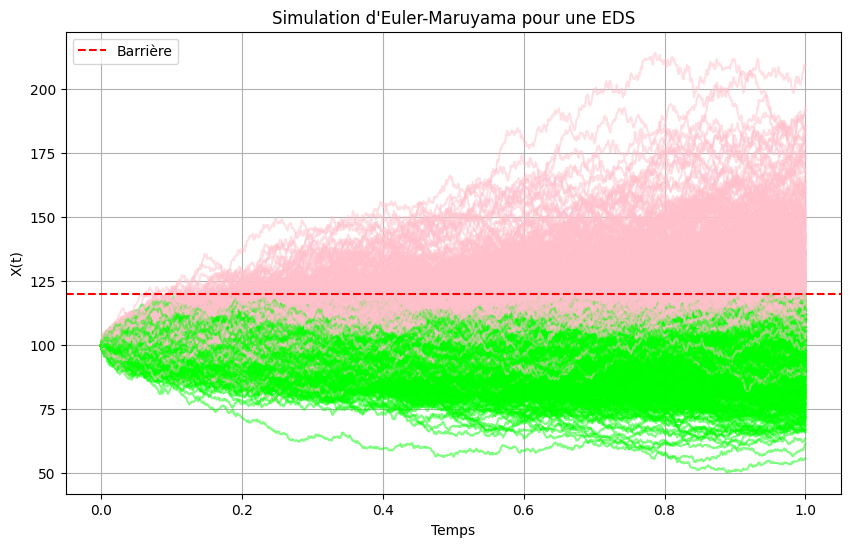

Moyenne des payoffs actualisés: 1.4768275985983736
Comparaison avec la formule de Black-Scholes: 17.998941120931214


In [7]:
N_trajectories = 1000
trajectories = [
    (t, X)
    for (t, X) in [
        euler_maruyama(mu=r, sigma=sigma, T=T, N=1000, X0=S0)
        for _ in range(N_trajectories)
    ]
]
plt.figure(figsize=(10, 6))
plot_browniens(trajectories, B=B)
plt.show()

payoffs = compute_payoff(trajectories, B, K)
payoffs_BS = compute_payoff_BS()
print("Moyenne des payoffs actualisés:", np.mean(payoffs))
print("Comparaison avec la formule de Black-Scholes:", payoffs_BS)

## Partie 3 : Analyse d'erreur et convergence

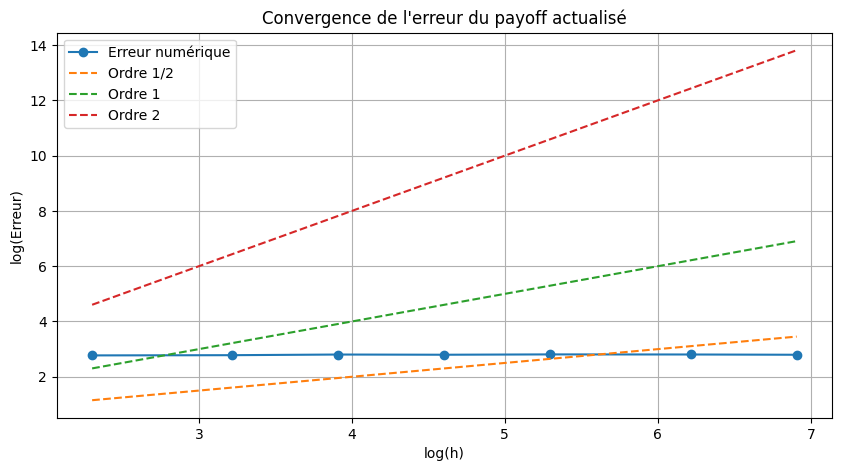

In [8]:
N_list = [10, 25, 50, 100, 200, 500, 1000]

np.random.seed(333)


def plot_payoff_errors():
    """Trace l'erreur de convergence du payoff actualisé en fonction de N."""
    errors = []

    for N in N_list:
        trajectories = [
            (t, X)
            for (t, X) in [
                euler_maruyama(mu=r, sigma=sigma, T=T, N=N, X0=S0)
                for _ in range(N_trajectories)
            ]
        ]
        payoff_BS = compute_payoff_BS()
        payoffs = compute_payoff(trajectories, B, K)

        errors.append(np.max(np.abs(payoffs - payoff_BS)))

    plt.plot(np.log(N_list), np.log(errors), "o-", label="Erreur numérique")
    plt.plot(np.log(N_list), 0.5 * np.log(N_list), "--", label="Ordre 1/2")
    plt.plot(np.log(N_list), np.log(N_list), "--", label="Ordre 1")
    plt.plot(np.log(N_list), 2 * np.log(N_list), "--", label="Ordre 2")
    plt.xlabel("log(h)")
    plt.ylabel("log(Erreur)")
    plt.title("Convergence de l'erreur du payoff actualisé")
    plt.legend()
    plt.grid(True)


plt.figure(figsize=(10, 5))
plot_payoff_errors()
plt.show()

*Question 2*: On observe que plus le pas de discrétisation est petit, plus l’approximation du payoff se rapproche de sa courbe réelle. Cela permet de mieux capturer les franchissements de barrière pouvant se produire entre deux instants de discrétisation, réduisant ainsi les erreurs liées à la non-détection de ces événements.